In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid, cumulative_trapezoid
import seaborn as sns

In [2]:
import scipy.stats as ss

stim_grid = np.linspace(0, np.pi*2., 500, False)
rep_grid = np.linspace(0, 1., 500, False)

In [3]:
def prior(x):
    return (2-np.abs(np.sin(2*x)))/ (np.pi-1)/4.0

def F(x):
    x_ = x % np.pi
    cdf = np.clip(
        (((np.cos(x_) ** 2) * np.sign(np.sin(2 * x_)) + 2 * x_) / (2 * (np.pi - 1.)) - (1 / (2 * (np.pi - 1.)))), 0,
        1.) * .5
    cdf += (x // np.pi) * .5
    return cdf

In [4]:
def stimulus_noise(x, sd, grid):
    return ss.vonmises(loc=x, kappa=1/sd**2).pdf(grid)

def sensory_noise(m, sd, grid):
    return ss.vonmises(loc=m*np.pi*2., kappa=1./(sd*np.pi*2.)**2).pdf(grid*np.pi*2)*np.pi*2.

In [5]:

def get_thetahat_dist(theta0, sigma_stim, sigma_rep, rep_grid=None, stim_grid=None, n_bins=100):

    if rep_grid is None:
        rep_grid = np.linspace(0, 1., 500, True)

    if stim_grid is None:
        stim_grid = np.linspace(0, np.pi*2., 500, True)


    # theta0 x theta_gen x m_gen
    # Add stimulus noise to get distribution of thetas given theta0
    p_theta_given_theta0 = stimulus_noise(theta0[:, np.newaxis], sd=sigma_stim, grid=stim_grid[np.newaxis, :])
    # Add sensory noise to see what ms you get given a theta 0
    p_m_given_theta0 = sensory_noise(F(stim_grid)[np.newaxis, :, np.newaxis], sd=sigma_rep, grid=rep_grid[np.newaxis, np.newaxis, :])
    
    # Combine sensory and stimulus noise
    p_m_given_theta0 = p_m_given_theta0 * p_theta_given_theta0[..., np.newaxis]

    # Integrate out different thetas, so we just have ms given theta0
    p_m_given_theta0 = trapezoid(p_m_given_theta0, stim_grid, axis=1)

    # Make a big array that for many thetas gives the probability of observing ms (subject likelihood)
    p_m_given_theta = stimulus_noise(stim_grid[:, np.newaxis], sd=sigma_stim, grid=stim_grid[np.newaxis, :])[..., np.newaxis] * \
                        sensory_noise(F(stim_grid)[np.newaxis, :, np.newaxis], sd=sigma_rep, grid=rep_grid[np.newaxis, np.newaxis, :])

    # Integrate out the realized thetas
    p_m_given_theta = trapezoid(p_m_given_theta, stim_grid, axis=1)

    # Multiply with prior on thetas
    p_theta_given_m = p_m_given_theta * prior(stim_grid)[:, np.newaxis]

    # Normalize with p(m)
    p_theta_given_m = p_theta_given_m / trapezoid(p_theta_given_m, stim_grid, axis=0)[np.newaxis, :]

    # theta0 x theta_tilde x m
    # Probability of estimating \hat{theta} given theta0
    p_thetaest_given_theta0 = p_m_given_theta0[:, np.newaxis, :] * p_theta_given_m[np.newaxis, ...]

    # Get rid of m
    p_thetaest_given_theta0 = trapezoid(p_thetaest_given_theta0, rep_grid, axis=2)

    # normalize (99% sure that not necessary)
    # p_thetaest_given_theta0 /= trapezoid(p_thetaest_given_theta0, stim_grid, axis=1)[:, np.newaxis]

    return p_thetaest_given_theta0


def expected_thetahat_theta0(theta0, sigma_stim, sigma_rep, rep_grid=None, stim_grid=None, kde_kappa=10):

    if rep_grid is None:
        rep_grid = np.linspace(0, 1., 200, True)

    if stim_grid is None:
        stim_grid = np.linspace(0, np.pi*2., 200, True)

    p_thetaest_given_theta0 = get_thetahat_dist(theta0, sigma_stim, sigma_rep, rep_grid=rep_grid, stim_grid=stim_grid)

    return np.angle(trapezoid(np.exp(1j*stim_grid[np.newaxis, :])*p_thetaest_given_theta0, stim_grid, axis=1)) % (2*np.pi)

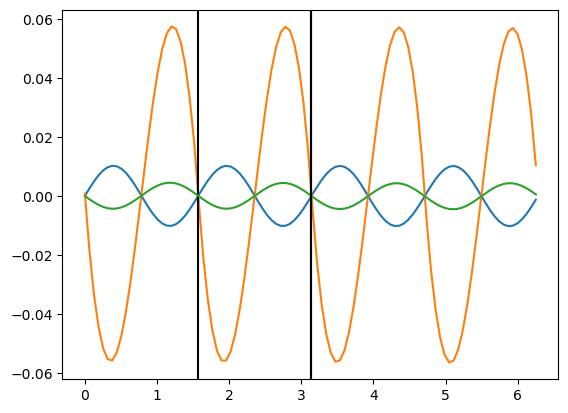

In [6]:
theta0 = np.linspace(0.001, 1.99*np.pi, 100)

E_theta_given_theta0 = expected_thetahat_theta0(theta0, 0.5, 0.01)
plt.plot(theta0, theta0 - E_theta_given_theta0)

E_theta_given_theta0 = expected_thetahat_theta0(theta0, 0.01, 0.05)
plt.plot(theta0, theta0 - E_theta_given_theta0)
plt.axvline(np.pi, c='k')
plt.axvline(0.5*np.pi, c='k')


E_theta_given_theta0 = expected_thetahat_theta0(theta0, 0.75, 0.05)
plt.plot(theta0, theta0 - E_theta_given_theta0)
plt.axvline(np.pi, c='k')

In [7]:
theta0 = np.linspace(0.001, 1.99*np.pi, 100)

def plot_bias(sigma_rep, sigma_stim):
    E_theta_given_theta0 = expected_thetahat_theta0(theta0, sigma_stim, sigma_rep)
    plt.plot(theta0, theta0 - E_theta_given_theta0)
    # sns.despine()
    plt.ylim(-0.1, 0.1)

In [8]:
from ipywidgets import interact

In [9]:
interact(plot_bias, sigma_rep=(0.001, 0.05, 0.005), sigma_stim=(0.01, 1., 0.01))

interactive(children=(FloatSlider(value=0.021, description='sigma_rep', max=0.05, min=0.001, step=0.005), Floa…

<function __main__.plot_bias(sigma_rep, sigma_stim)>